In [31]:
import pandas as pd
import numpy as np
from math import e as euler
from IPython.display import SVG
import sklearn.datasets as data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree
import seaborn as sb

In [50]:
# fetch data
dummy = data.fetch_california_housing()
df = pd.DataFrame(dummy.data, columns = dummy.feature_names)
df['HouseValue'] = dummy.target

# df = pd.read_csv('d2.txt', delim_whitespace=True)

# bin out data
def binVariable(df, variable):
    q0 = np.min(df[variable])
    q20 = np.percentile(df[variable], 20)
    q40 = np.percentile(df[variable], 40)
    q60 = np.percentile(df[variable], 60)
    q80 = np.percentile(df[variable], 80)
    q100 = np.max(df[variable])
    values = []
    for item in df[variable]:
        if q0 <= item < q20:
            values.append(1)
        elif q20 <= item < q40:
            values.append(2)
        elif q40 <= item < q60:
            values.append(3)
        elif q60 <= item < q80:
            values.append(4)
        elif q80 <= item <= q100:
            values.append(5)
        else:
            raise ValueError("Can't classify " + str(item) + " by its quartile")
    variable_bin = variable + "_bin"
    df[variable_bin] = values
binVariable(df, 'HouseValue')
binVariable(df, 'MedInc')
print(df['AveBedrms'].mean())
df.head()


1.096675149606208


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseValue,HouseValue_bin,MedInc_bin
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,5,5
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,5,5
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,5,5
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,5,5
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,5,3


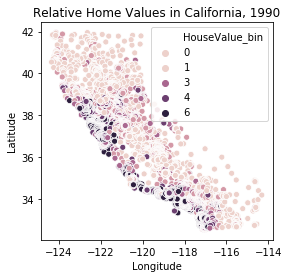

In [51]:
# visualize the housing districts
hueVar = 'HouseValue_bin'
plt.title("Relative Home Values in California, 1990")
plt.gca().set_aspect('equal', adjustable='box')
sb.scatterplot(x='Longitude', y='Latitude', hue=hueVar, data=df)

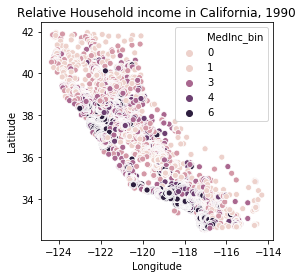

In [9]:
# visualize the income distribution
hueVar = 'MedInc_bin'
plt.title("Relative Household income in California, 1990")
plt.gca().set_aspect('equal', adjustable='box')
sb.scatterplot(x='Longitude', y='Latitude', hue=hueVar, data=df)

In [5]:
# build and test the classifier
def learn(df, testingVar, droppedAttributes):
    training, testing = train_test_split(df, test_size=.15)
    treeclf = DecisionTreeClassifier(max_depth=10, random_state=2)
    treeclf.fit(training.drop(droppedAttributes, 1), training[testingVar])
    y_pred = treeclf.predict(testing.drop(droppedAttributes, 1))
    p,r,f,s = precision_recall_fscore_support(testing[testingVar], y_pred)
    print('\nF1 Scores for each class, predicting on ' + testingVar)
    for fScore in f:
        print(fScore)
    return treeclf

# Predict on different attributes
houseValue_dropped = ['HouseValue', 'MedInc_bin', 'HouseValue_bin']
tree_houseValue = learn(df, 'HouseValue_bin', houseValue_dropped)
medianIncome_dropped = ['MedInc', 'MedInc_bin', 'HouseValue_bin']
tree_medianIncome = learn(df, 'MedInc_bin', medianIncome_dropped)


F1 Scores for each class, predicting on HouseValue_bin
0.7284878863826233
0.5221595487510072
0.46204620462046203
0.5300462249614791
0.7218649517684887

F1 Scores for each class, predicting on MedInc_bin
0.6591820368885324
0.46153846153846156
0.41506276150627613
0.4874493927125506
0.742671009771987


In [6]:
# create a Graphviz file
def createGraphic(df, dropped, treeclf, testingVar):
    classNames = ['1', '2', '3', '4', '5']
    features = df.drop(dropped, 1).columns
    f = export_graphviz(treeclf,
                        out_file=open(testingVar + ".dot", 'w'),
                        feature_names=features,
                        class_names=classNames,
                        filled = True)
    graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                        feature_names=features,
                                        class_names=classNames, filled = True))
    svg = SVG(graph.pipe(format='svg'))
    return svg

houseValues_graphic = createGraphic(df, houseValue_dropped, tree_houseValue, 'HouseValue')
income_graphic = createGraphic(df, medianIncome_dropped, tree_medianIncome, 'MedInc')


In [29]:
# display one of the graphics at a time
display(houseValues_graphic)

In [22]:
# Visulize F1 Score performance
houseValueScores = [
0.7284878863826233,
0.5221595487510072,
0.46204620462046203,
0.5300462249614791,
0.7218649517684887,
]

medIncomeScores = [
0.6591820368885324,
0.46153846153846156,
0.41506276150627613,
0.4874493927125506,
0.742671009771987,
]

house_df = pd.DataFrame({
    'Percentile Classification': ['0-20', '20-40', '40-60', '60-80', '80-100'],
    'F1 Score': houseValueScores
})

income_df = pd.DataFrame({
    'Percentile Classification': ['0-20', '20-40', '40-60', '60-80', '80-100'],
    'F1 Score': medIncomeScores
})


In [28]:
print(house_df['F1 Score'].mean())
print(income_df['F1 Score'].mean())

0.5929209632968121
0.5531807324835615


Text(0.5, 1.0, 'Predicting Median Home Value')

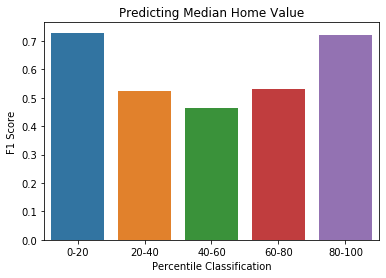

In [23]:
sb.barplot(x='Percentile Classification', y='F1 Score', data=house_df).set_title("Predicting Median Home Value")

Text(0.5, 1.0, 'Predicting Median Income')

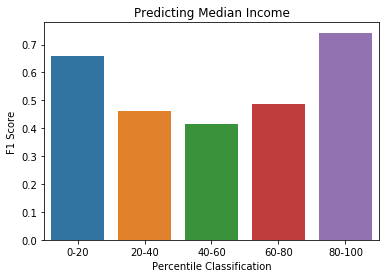

In [24]:
sb.barplot(x='Percentile Classification', y='F1 Score', data=income_df).set_title("Predicting Median Income")